In [1]:
import numpy as np
from collections import defaultdict
import random
from tqdm import trange
import copy
import networkx as nx
import matplotlib.pyplot as plt
import sys
import igraph
from matplotlib import cm, colors
random.seed(42)
import seaborn as sns
from abstract_environments import * #ContinuousTMaze, GridEnvRightDownNoCue, GridEnvRightDownNoSelf, GridEnvDivergingMultipleReward, GridEnvDivergingSingleReward
from util import *
# from util import transition_matrix_action

Simulating experiments described in this paper: [The role of prospective contingency in the control of behavior and dopamine signals during associative learning](https://pmc.ncbi.nlm.nih.gov/articles/PMC10871210/#S30) (Qian et al., 2024 bioRxiv)

our hypothesis:

degradation --> less split in delay. so more stochastic, therefore devaluation of A

cued reward --> delay splits. therefore no devaluation of A


In [2]:
lam=0.8
gamma = 0.1

In [3]:
for i in range(100):
    print(np.random.binomial(n=1, p=1))

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


# 1. Degradation

In [4]:
# coding: 1 = A, 4 = B, 2 = R, 3 = nR, 0 = delay
observation_1 = [1,0,2] # start 1, left turn, rewarded
observation_2 = [1,0,3] # start 1, left turn, rewarded
observation_3 = [4,0,3] # start 2, right turn, rewarded
observation_4 = [0,2] # start 1, right turn, no reward
observation_5 = [0,3] # start 2, left turn, no reward
# 2: left turn, 4: right turn, 5: reward, 6: no reward
actions_1 = [0,0]
actions_2 = [0,0]
actions_3 = [0,0]
actions_4 = [0]
actions_5 = [0]

a = 1
b = 4
r = 2
nr = 3
d = 0

super_observations = (([observation_1] * 30) +
                     ([observation_2] * 10) +
                     ([observation_3] * 20) +
                     ([observation_4] * 30) + 
                     ([observation_5] * 10))
# and similarly for actions:
super_actions =( ([actions_1] * 30) +
                ([actions_2] * 10) +
                ([actions_3] * 20) +
                ([actions_4] * 30) +
                ([actions_5] * 10))

combined = list(zip(super_observations, super_actions))
random.shuffle(combined)
super_observations, super_actions = zip(*combined)  # unzip

dataset=[]
for l in range(len(super_observations)):
    dataset.append([super_observations[l], super_actions[l]])



transition_counts = transition_matrix_action(dataset)
denominators = transition_counts.sum(axis=2, keepdims=True)
denominators[denominators == 0] = 1
transition_probs = transition_counts / denominators
# denominators.shape
actions = [0]
iterations=20
used_cues = []
# clone_map = []
clone_dict = {}
reverse_clone_dict = {}
graphiter = 0
savename='tmaze'
# plot_graph_nogrid(transition_probs,'initial',savename=savename)  
# Actual code
for i in range(iterations):
    print("Iteration {}".format(i))
    entropies = compute_transition_entropies(transition_probs)
    stochastic_pairs = find_stochastic_state_actions_by_entropy(entropies, eps=1e-9) # (s,a,sprime,sprime2)
    
    if stochastic_pairs: 
        cues = []
        for (s, a) in stochastic_pairs:
            print("Stochastic pairs: {}".format((s,a)))
            # if len(vali)
            # valid_actions = env.get_valid_actions(s)
            sprime, sprime2 = get_successor_states(transition_counts,s,a)
            cue = calculate_contingency_tmaze(dataset, s, sprime, sprime2)
            print(cue)
            cues.append(cue)
            
        # split out the successor states
        unique_cues = np.unique([x for sublist in cues for x in sublist])
        print(unique_cues)
        split = False
        
        for cue in unique_cues:
            if cue in used_cues: 
                continue
            if split == True: 
                continue
            if cue > 6:
                print("Current cue: {} (clone of {})".format(cue, clone_dict[cue]))
            else:
                print("Current cue: {}".format(cue))
            
            # if cue not in used_cues:
            split=True # just split one at a time
            # valid actions
            # valid_actions = env.get_valid_actions(cue)
            # for a in valid_actions:  
            # if cue > 6: # cloned state, so need to get the valid actions from the original state
            #     valid_actions = env.get_valid_actions(clone_dict[cue])
            # else:
            #     valid_actions = env.get_valid_actions(cue)
            # clone_orig = clone_dict[]
            for a in actions:
                # print(cue,a)
                if get_successor_states(transition_counts,cue,a).size>0:
                    successor = get_successor_states(transition_counts,cue,a)[0] # suppose 7
                    # if reverse_clone_dict[successor]: # this has been created before
                    if successor in reverse_clone_dict:
                        existing_clone = reverse_clone_dict[successor]
                        for d, seq in enumerate(dataset):
                            states_seq = seq[0]
                            if has_state(states_seq, successor): # get all the sequence that has 7
                                if has_transition(cue, successor,states_seq): # this is sequence that 6->7, clone 7
                                    # 1. modify dataset

                                    dataset[d][0] = [existing_clone if x==successor else x for x in dataset[d][0]] 

                    else:    # hasn't been created before. split        
                        # split this as a function of whether it came from cue (6) vs. others
                        # has_state(sequence,)
                        n_unique_states = len(get_unique_states(dataset))
                        new_clone = n_unique_states + 1            
                        
                        # clone_map.append((successor,new_clone))
                        clone_dict[new_clone] = successor
                        reverse_clone_dict[successor] = new_clone
                        for d, seq in enumerate(dataset):
                            states_seq = seq[0]
                            if has_state(states_seq, successor): # get all the sequence that has 7
                                if has_transition(cue, successor,states_seq): # this is sequence that 6->7, clone 7
                                    # 1. modify dataset

                                    dataset[d][0] = [new_clone if x==successor else x for x in dataset[d][0]] 
                    # 2. modify transition count
                    transition_counts = transition_matrix_action(dataset)
                    denominators = transition_counts.sum(axis=2, keepdims=True)
                    denominators[denominators == 0] = 1
                    transition_probs = transition_counts / denominators
                    # graphiter = 0
                    # plot_graph_nogrid(transition_probs,graphiter, cue, new_clone,savename=savename)
                    graphiter+=1
            used_cues.append(cue)
    
        print('\n')
    else:
        print('Finished splitting at iteration {}'.format(i))
        break        
# plot_graph_nogrid(transition_probs,'final', savename=savename)    

Iteration 0
Stochastic pairs: (0, 0)
[2]
[2]
Current cue: 2


Iteration 1
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 2
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 3
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 4
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 5
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 6
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 7
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 8
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 9
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 10
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 11
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 12
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 13
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 14
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 15
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 16
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 17
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 18
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 19
Stochastic pairs: (0, 0)
[2]
[2]




In [5]:
a = 1
b = 4
r = 2
nr = 3
d = 0

In [6]:
E_r, E_nr = conditioned_eligibility_traces(dataset, r, nr, lam=lam, gamma=gamma)

In [7]:
print(E_r, '\n', E_nr)

[[43.2   15.552 60.     0.     0.   ]] 
 [[28.8    5.184  0.    40.    10.368]]


In [8]:
E_r[E_r==0] = 1e-3
# E_nr[E_nr==0] = 1e-3
E_c = E_r / (E_r + E_nr )    
E_c


array([[6.00000000e-01, 7.50000000e-01, 1.00000000e+00, 2.49993750e-05,
        9.64413155e-05]])

<Axes: >

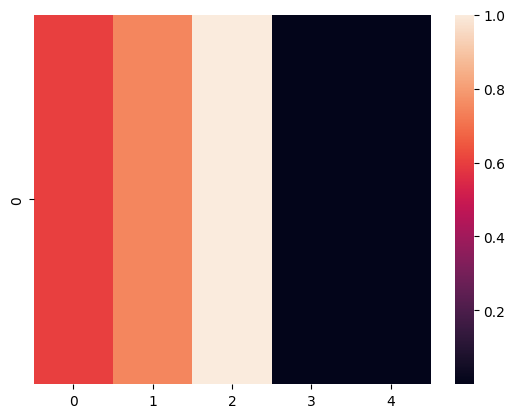

In [9]:
sns.heatmap(E_c)

# 2. Cued Reward

In [10]:
# coding: 1 = A, 4 = B, 2 = R, 3 = nR, 0 = delay
observation_1 = [1,0,2] # start 1, left turn, rewarded
observation_2 = [1,0,3] # start 1, left turn, rewarded
observation_3 = [4,0,3] # start 2, right turn, rewarded
observation_4 = [5,0,2] # start 1, right turn, no reward
observation_5 = [5,0,3] # start 2, left turn, no reward
# 2: left turn, 4: right turn, 5: reward, 6: no reward
actions_1 = [0,0]
actions_2 = [0,0]
actions_3 = [0,0]
actions_4 = [0,0]
actions_5 = [0,0]

a = 1
b = 4
r = 2
nr = 3
d = 0
c = 5

super_observations = (([observation_1] * 30) +
                     ([observation_2] * 10) +
                     ([observation_3] * 20) +
                     ([observation_4] * 30) + 
                     ([observation_5] * 10))
# and similarly for actions:
super_actions =( ([actions_1] * 30) +
                ([actions_2] * 10) +
                ([actions_3] * 20) +
                ([actions_4] * 30) +
                ([actions_5] * 10))

combined = list(zip(super_observations, super_actions))
random.shuffle(combined)
super_observations, super_actions = zip(*combined)  # unzip

dataset=[]
for l in range(len(super_observations)):
    dataset.append([super_observations[l], super_actions[l]])



transition_counts = transition_matrix_action(dataset)
denominators = transition_counts.sum(axis=2, keepdims=True)
denominators[denominators == 0] = 1
transition_probs = transition_counts / denominators
# denominators.shape
actions = [0]
iterations=20
used_cues = []
# clone_map = []
clone_dict = {}
reverse_clone_dict = {}
graphiter = 0
savename='tmaze'
# plot_graph_nogrid(transition_probs,'initial',savename=savename)  
# Actual code
for i in range(iterations):
    print("Iteration {}".format(i))
    entropies = compute_transition_entropies(transition_probs)
    stochastic_pairs = find_stochastic_state_actions_by_entropy(entropies, eps=1e-9) # (s,a,sprime,sprime2)
    
    if stochastic_pairs: 
        cues = []
        for (s, a) in stochastic_pairs:
            print("Stochastic pairs: {}".format((s,a)))
            # if len(vali)
            # valid_actions = env.get_valid_actions(s)
            sprime, sprime2 = get_successor_states(transition_counts,s,a)
            cue = calculate_contingency_tmaze(dataset, s, sprime, sprime2)
            print(cue)
            cues.append(cue)
            
        # split out the successor states
        unique_cues = np.unique([x for sublist in cues for x in sublist])
        print(unique_cues)
        split = False
        
        for cue in unique_cues:
            if cue in used_cues: 
                continue
            if split == True: 
                continue
            if cue > 6:
                print("Current cue: {} (clone of {})".format(cue, clone_dict[cue]))
            else:
                print("Current cue: {}".format(cue))
            
            # if cue not in used_cues:
            split=True # just split one at a time
            # valid actions
            # valid_actions = env.get_valid_actions(cue)
            # for a in valid_actions:  
            # if cue > 6: # cloned state, so need to get the valid actions from the original state
            #     valid_actions = env.get_valid_actions(clone_dict[cue])
            # else:
            #     valid_actions = env.get_valid_actions(cue)
            # clone_orig = clone_dict[]
            for a in actions:
                # print(cue,a)
                if get_successor_states(transition_counts,cue,a).size>0:
                    successor = get_successor_states(transition_counts,cue,a)[0] # suppose 7
                    # if reverse_clone_dict[successor]: # this has been created before
                    if successor in reverse_clone_dict:
                        existing_clone = reverse_clone_dict[successor]
                        for d, seq in enumerate(dataset):
                            states_seq = seq[0]
                            if has_state(states_seq, successor): # get all the sequence that has 7
                                if has_transition(cue, successor,states_seq): # this is sequence that 6->7, clone 7
                                    # 1. modify dataset

                                    dataset[d][0] = [existing_clone if x==successor else x for x in dataset[d][0]] 

                    else:    # hasn't been created before. split        
                        # split this as a function of whether it came from cue (6) vs. others
                        # has_state(sequence,)
                        n_unique_states = len(get_unique_states(dataset))
                        new_clone = n_unique_states + 1            
                        
                        # clone_map.append((successor,new_clone))
                        clone_dict[new_clone] = successor
                        reverse_clone_dict[successor] = new_clone
                        for d, seq in enumerate(dataset):
                            states_seq = seq[0]
                            if has_state(states_seq, successor): # get all the sequence that has 7
                                if has_transition(cue, successor,states_seq): # this is sequence that 6->7, clone 7
                                    # 1. modify dataset

                                    dataset[d][0] = [new_clone if x==successor else x for x in dataset[d][0]] 
                    # 2. modify transition count
                    transition_counts = transition_matrix_action(dataset)
                    denominators = transition_counts.sum(axis=2, keepdims=True)
                    denominators[denominators == 0] = 1
                    transition_probs = transition_counts / denominators
                    # graphiter = 0
                    # plot_graph_nogrid(transition_probs,graphiter, cue, new_clone,savename=savename)
                    graphiter+=1
            used_cues.append(cue)
    
        print('\n')
    else:
        print('Finished splitting at iteration {}'.format(i))
        break        
# plot_graph_nogrid(transition_probs,'final', savename=savename)    

Iteration 0
Stochastic pairs: (0, 0)
[2]
[2]
Current cue: 2


Iteration 1
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 2
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 3
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 4
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 5
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 6
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 7
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 8
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 9
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 10
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 11
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 12
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 13
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 14
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 15
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 16
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 17
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 18
Stochastic pairs: (0, 0)
[2]
[2]


Iteration 19
Stochastic pairs: (0, 0)
[2]
[2]




In [11]:
E_r, E_nr = conditioned_eligibility_traces(dataset, r, nr, lam=lam, gamma=gamma)
print(E_r, '\n', E_nr)

[[43.2   15.552 60.     0.     0.    15.552]] 
 [[28.8    5.184  0.    40.    10.368  5.184]]


<Axes: >

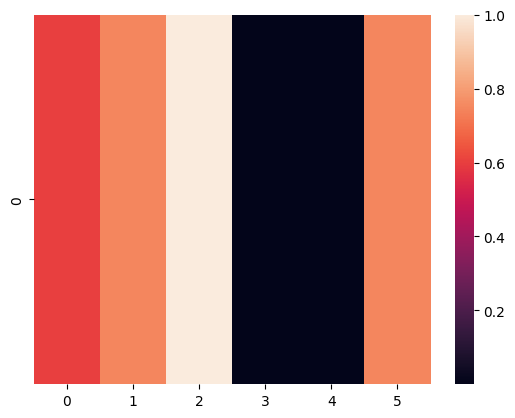

In [12]:
E_r[E_r==0] = 1e-3
# E_nr[E_nr==0] = 1e-3
E_c = E_r / (E_r + E_nr )    
E_c
sns.heatmap(E_c)